# Final Report

1. [Executive Summary](#1.-Executive-Summary)


2. [Aim and Background](#2.-Aim-and-Background)

    2.1 [Problem](#2.1-Problem)
    
    2.2 [Aim](#2.2-Aim)
    
    2.3 [Background](#2.3-Background)
    
    
3. [Methods](#3.-Methods)
   
   3.1 [Data Collection](#3.1.-Data-Collection)
   
   3.2 [Data Preprocessing](#3.2.-Data-Preprocessing)
   
   3.3 [Models](#3.3-Models)
   
   3.4 [Evaluation Strategies](#3.4.-Evaluation-Strategies)
   
   
4. [Results](#4.-Results)

   4.1 [Part A - Evaluation](#4.1-Part-A---Evaluation-Results)
   
   4.2 [Part B - Product Results](#4.2-Part-B)
   
   
5. [Discussion and Conclusion](#5.-Discussion-and-Conclusion)

  5.1 [Issues Addressed](#5.1-Issues-Addressed)
  
  5.2 [Future Work](#5.2-Future-Work)
  
  
6. [Student Contributions](#6.-Student-Contribution)

  
7. [References](#7.-References)

## 1. Executive Summary

Patients suffering from motor-neuron diseases experience difficulty communicating through traditional input devices such as keyboards. However, in most cases, patients retain functionality of the eyes, thus opening a potential channel for communication. In the present work, an innovative virtual keyboard using eye movements was developed for patients with limited motor function and speech. Using an electrooculography (EOG) based human-computer interface, eye movements were encoded to operate an intuitive binary tree keyboard. By enabling them to type and communicate by digital means, our solution has potential to significantly improve a patients quality of life.

The final implementation consists of four distinct stages: data acquisition, processing, classification and user interface, bridging the gap between physics and data science.  The physics colleagues designed and evaluated digital filters to de-noise SpikerBox data, finding that the Butterworth low-pass filter provided the ideal balance between project requirements and computational cost. Three machine learning classification schemes were evaluated using graphical, qualitative and quantitative methods. With consideration to the end-user, speed was selected as a key metric for model analysis as the keyboard should have minimal delay between action execution and realization in the virtual environment. Moreover, the classification model must be generalisable and demonstrate a high degree of accuracy across all users in order to be a viable solution. Finally, a virtual keyboard requires a low false discovery rate (FDR) as misidentifying inputs would be more detrimental to user-experience than a non-event. Using the aforementioned criteria, it was determined that an artificial neural network (ANN) was the optimal classification model for a virtual keyboard. 


#### Figure 1: Data-flow Diagram
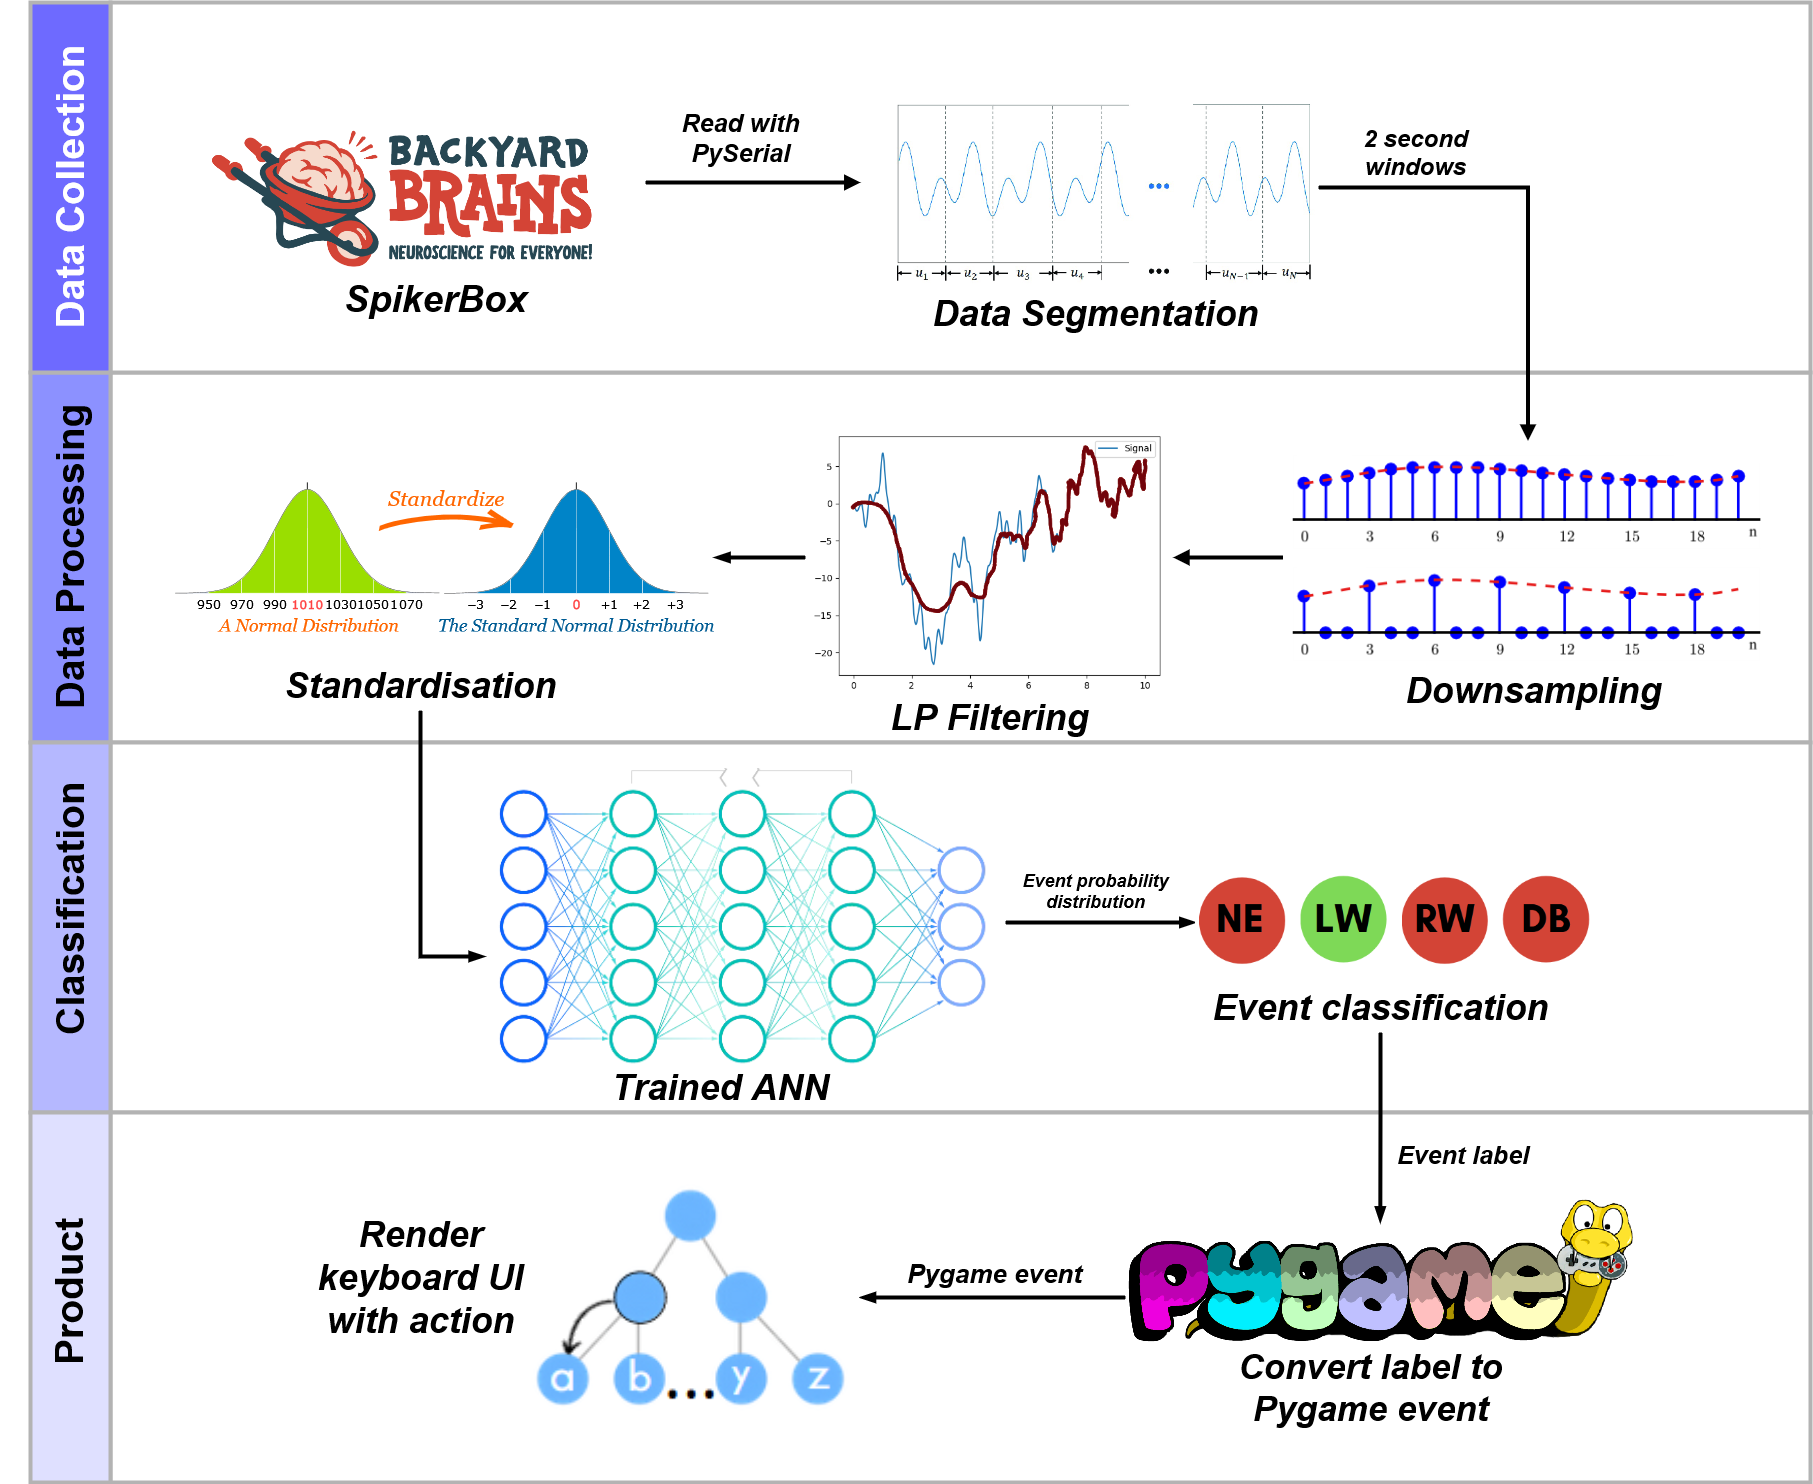

## 2. Aim and Background

### 2.1 Problem

Every day, hundreds of people around the world are diagnosed with motor neurone diseases. ("What is ALS/MND?", 2022).
Patients often have trouble communicating, mostly due to the damage which is caused to the neurons responsible for the functioning of the mouth, tongue and/or larynx. They also often have difficulty using their hands due to a weak grip, muscle cramps and twitches. As a result, patients have trouble using input devices such as keyboards that require hands as well as alternative methods like speech-to-text.



### 2.2 Aim

Our goal was to provide an alternate method for patients with limited motor function and speech to communicate and type. We decided to develop an efficient and intuitive virtual keyboard layout which would use eye movements as input, as this is one of the only modes of communication retained by patients. Minimization of user fatigue was a key goal in the design of the product, as sick patients using it would be more prone to fatigue than the average person.

### 2.3 Background

#### 2.3.1 SpikerBox and Electrooculography (EOG)

As a result of its bioelectromagnetic complexities, a potential exists between the cornea and retina in the eye. This system can effectively be modeled as a single dipole in which motion of the eye results in a change of dipole orientation, inducing a measurable change in the electric potential field it generates. When situated between two electrodes placed on opposite sides of the eye, this change in potential produces a characteristic signal known as an electrooculogram (EOG) (Bulling 2009). 

The SpikerBox, a low cost, open-source bio amplifier with EOG capabilities, was utilized for data acquisition. As each eye movement has a characteristic waveform and amplitude pattern, motion such as left and right gazes as well as blinks and winks can be differentiated using information encoded in the EOG spike signal. On the basis, it is possible to classify and assign eye movements to a discrete set of user-inputs to interact with virtual environments.


#### 2.3.2 Classification and User Interface

To generate control commands for the virtual keyboard from the time-series of EOG data, intentional eye movements were classified in real-time. In addition to demonstrating a high degree of fidelity and efficiency, the implemented classification scheme must be flexible and adaptive. For this reason, three machine learning classification schemes (feed-forward ANN, Support Vector Machine (SVM) and Random Forest) were evaluated with the optimal scheme being employed in the final solution. A Pygame-based UI that is fed event labels in real-time renders the virtual keyboard layout and updates according to the user input.

## 3. Methods


Our method involved a multidisciplinary integration between three different disciplines: physics, data science, and software. Although each discipline contributed to all sections, there was a stronger need for physics students in the data collection/pre-processing phase, data students in the pre-processing/classification phase, and software students in the keyboard UI stage.

### 3.1. Data Collection

The first stage of our method is data collection.

The EOG signal is measured with a SpikerBox, which has a sampling rate of 10kHz. An electrode was placed on either side of the eyes and another under the ear, which transfer the signal to the device then to a laptop via USB where it is analyzed.

Data was collected using an custom developed interface involving the user following a green circle around the screen which at random intervals displays one of the three actions (left wink, right wink or double blink). The random movement of the circle simulates the eye movement of the user when using the product, which will be traveling around the keyboard looking for the next letter to type. Hence, this makes the data collected more realistic, thus increasing the performance of classification when transferred over to real life data.

In [ ]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# CONFIG

EVENT_ID_MAP = {
    None: 0,
    "L": 1,
    "R": 2,
    "S": 3,
}
EVENT_ID_LETTER_MAP = {EVENT_ID_MAP[i]:i for i in EVENT_ID_MAP}

EVENT_COLOR_MAP = {
    None: "black",
    "L": "red",
    "R": "blue",
    "S": "green",
}

EVENT_ID_NAME_MAP = {
    0: "Nothing",
    1: "Left Wink",
    2: "Right Wink",
    3: "Dbl Blink",
}

BRAINBOX_SAMPLE_RATE = 10000

DOWNSAMPLE_RATE = 100

FILTER_DATA = True
FILTER_CUTOFF = 7

NORMALISE_DATA = True

EVENT_LENGTH = 2 # length of a given event sequence in seconds
EVENT_SAMPLE_COUNT = int(EVENT_LENGTH * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE) # size of event in samples

EVENT_START = -0.75
EVENT_START_OFFSET = int(EVENT_START * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

EVENT_END = -0.25
EVENT_END_OFFSET = int(EVENT_END * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

INPUT_SHAPE = (EVENT_SAMPLE_COUNT,)
OUTPUT_SHAPE = len(EVENT_ID_MAP)  # number of categories (including None)

EVENTS_PATH = "../src/data_collection/data/events/"
SAMPLES_PATH = "../src/data_collection/data/waves/"

FILE_NAMES_ALL = [
#     "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
#     "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
#     "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
#     "DATA_2022-05-13_Josh_0001_6_1652406023",
#     "DATA_2022-05-13_Josh_0001_6_1652406202",
#     "DATA_2022-05-13_Josh_0001_7_1652406589",
#     "DATA_2022-05-13_Josh_0001_7_1652406788",
#     "DATA_2022-05-13_Josh_0001_8_1652407331",
#     "DATA_2022-05-13_Josh_0001_8_1652407508",
]

In [ ]:
def load_sample_data(file_path:str):
    samples_df = pd.read_csv(
        f"{file_path}.csv",
    )

    # Sort because some samples are not written in order
    samples_df = samples_df.sort_values("time_sec", ascending=True)
    samples_df.reset_index(drop=True, inplace=True)

    return samples_df

In [ ]:
def load_event_data(file_path:str, event_id_map:dict, event_color_map:dict):
    """ Reads brainbox event data into a data frame """

    events_df = pd.read_csv(
        f"{file_path}.csv",
        names=["time_sec", "event_letter", "event_name"],
        header=0,
    )

    events_df["event_id"] = events_df["event_letter"].map(event_id_map)
    events_df["event_color"] = events_df["event_letter"].map(event_color_map)

    return events_df



In [ ]:
def merge_samples_events(
    samples_df,
    events_df,
    event_start:float,
    event_end:float,
    event_id_map:dict,
    event_color_map:dict,
):
    """
    Merges the sample and event dataframes.

    Events will be assigned to individual samples within a specified time range around the market.
    """
    # Add target classification event to each sample
    merge_df = samples_df.copy()

    # Default is None (no event)
    merge_df["event_letter"] = None
    merge_df["event_name"] = "Nothing"
    merge_df["event_id"] = event_id_map[None]
    merge_df["event_color"] = event_color_map[None]
    #print(sample_100_df)

    # Assign all events within range around their event marker
    for idx,row in events_df.iterrows():
        # Skip blinks for now
        # if row["event_type"] not in ["Left", "Right"]:
        #     continue

        event_interval = (merge_df["time_sec"] > (row["time_sec"] + event_start))
        event_interval &= (merge_df["time_sec"] < (row["time_sec"] + event_end))
        
        merge_df.loc[event_interval,"event_id"] = row["event_id"]
        merge_df.loc[event_interval,"event_name"] = row["event_name"]
        merge_df.loc[event_interval,"event_color"] = row["event_color"]

    return merge_df

### 3.2. Data Preprocessing

Our data pre-processing pipeline consists of four steps.

#### 3.2.1 Downsampling

The first step of preprocessing is to mean-downsample the wave stream by a factor of 100, reducing the sample rate of the waveform from 10kHz to 100Hz. This transformation preserves the majority of the wave structure whilst simultaneously reducing the time it takes to perform the later data transformations as there are 100 times less values. Downsampling also reduces the risk of overfitting in the model as the input size is smaller.

In [ ]:
def data_downsample(sample_df, n=100):
    """
    Downsamples the wave data (not events) to 1/nth of a second by taking mean sample over that period.
    """
    # Crop size to allow downsampling
    sample_df = sample_df[:len(sample_df) - (len(sample_df)%n)]
    
    return pd.DataFrame({
        "time_sec": np.min(np.array(sample_df["time_sec"]).reshape(-1,n), 1),
        "sample": np.mean(np.array(sample_df["sample"]).reshape(-1,n), 1),
    })

#### 3.2.2 Data Segmentation

In [ ]:
def data_segmentation(merge_df, event_sample_count:int, filter_data:bool):
    """
    Returns a list of each time series sequence labelled by the event.
    """
    print("Transforming data into individual segments...")

    seqs = []
    labels = []

    for idx,row in merge_df[:-event_sample_count].iterrows():
        label = row["event_id"]
        if label is None:
            label = -1
        labels.append(label)

        seq = list(merge_df["sample"][idx:idx+event_sample_count])
        seqs.append(seq)

    seqs = np.array(seqs)
    labels = np.array(labels)

    print(f"Transformed into {seqs.shape[0]} segments of size {seqs.shape[1]}")
    
    return (seqs, labels)

The next step of preprocessing is to splice the continuous stream of waveform data into chunks of length 2 seconds. This value was chosen as it was found to be long enough to contain the entire perturbation caused by a given action (e.g. Double Blink, Left Wink). This transformation is crucial as it generates input vectors of a standardized length (2 seconds x 100Hz = 200 values), allowing us to pass the waveform input directly into our machine learning model of choice.

#### 3.2.3 Filtering

In [205]:
# Butterworth filter
def data_filter(rawData, order:int=5, cutOff:int=7, Fs:int=10000):
    """
    Low pass
    cutOff in Hz
    """
    b, a = signal.butter(order, Wn=cutOff/(Fs/2)) 
    # Zero Phase double filter
    filteredSignal = signal.filtfilt(b, a, rawData)
    return filteredSignal

In typical operating environments, EOG signals can become contaminated by artifacts arising from muscle contractions, head-movements, and electromagnetic disturbances from power-line interference. To avoid inclusion of unwanted noise, it is necessary to remove high frequency contributions from these sources, while retaining the original signal of interest. A frequency spectrum analysis of raw EOG signals revealed that eye-movement is encoded within the sub-10 Hz range. On this basis, a low-pass Butterworth filter was selected for signal denoising.Optimal cut-off frequency was empirically determined to be 7Hz, while a fifth order filter provided the best trade-off between steepness of roll-off and computational cost. 

#### 3.2.4 Normalization

Another preprocessing step is the normalization of the signal. The signal can be influenced by factors such as electrode placement next to the eyes, and different individuals which can vary between data collection sessions. By normalizing the signals with a reference value, it is possible to more accurately compare and identify events produced. This is required to perform classification on these events.

In [206]:
def data_normalise(data):
    return (data - data.mean()) / data.std()


In [207]:
print("Data Preprocessing\n")
files_data_all = []
files_labels_all = []

for file_name in FILE_NAMES_ALL:
    start_time = time.time()

    print(f"Loading sample file '{file_name}'")
    samples_df = load_sample_data(SAMPLES_PATH + file_name)
    print(f"Loaded {len(samples_df)} samples")
    
    print(f"Downsampling @ n={DOWNSAMPLE_RATE}")
    samples_df = data_downsample(samples_df, n=DOWNSAMPLE_RATE)
    print(f"Downsampled to {len(samples_df)} samples")

    print(f"Loading event file '{file_name}'")
    events_df = load_event_data(
        file_path = EVENTS_PATH + file_name,
        event_id_map = EVENT_ID_MAP,
        event_color_map = EVENT_COLOR_MAP,
    )
    print(f"Loaded {len(events_df)} events")

    print(f"Merging samples and events")
    merge_df = merge_samples_events(
        samples_df, events_df,
        event_start = EVENT_START,
        event_end = EVENT_END,
        event_id_map = EVENT_ID_MAP,
        event_color_map = EVENT_COLOR_MAP,
    )
#     print("Merge complete")

    # Segment data for ML model input
    seq_data, seq_labels = data_segmentation(
        merge_df,
        event_sample_count=EVENT_SAMPLE_COUNT,
        filter_data=FILTER_DATA,
    )

    # Apply filters before we do the normalisation
    # One reason is that mains 50Hz will increase std for that sample
    if FILTER_DATA:
        for i,seq in enumerate(seq_data):
            seq_data[i] = data_filter(seq, cutOff=FILTER_CUTOFF, Fs=100) # Account for downsampling

    # Normalise relative to the 2 second interval
    # Note that this method will scale non-actions to have large magnitudes
    if NORMALISE_DATA:
        for i,seq in enumerate(seq_data):
            seq_data[i] = data_normalise(seq)

    files_data_all.append(seq_data)
    files_labels_all.append(seq_labels)

    print(f"Loaded and preprocessed file data in {time.time()-start_time:.2f}s")
    print("")
    
print("Finished data preprocessing")

Data Preprocessing

Loading sample file 'DATA_2022-05-13_Josh_0001_3_1652400939'
Loaded 1675296 samples
Downsampling @ n=100
Downsampled to 16752 samples
Loading event file 'DATA_2022-05-13_Josh_0001_3_1652400939'
Loaded 42 events
Merging samples and events
Transforming data into individual segments...
Transformed into 16552 segments of size 200
Loaded and preprocessed file data in 5.33s

Loading sample file 'DATA_2022-05-13_Josh_0001_4_1652401740'
Loaded 1735168 samples
Downsampling @ n=100
Downsampled to 17351 samples
Loading event file 'DATA_2022-05-13_Josh_0001_4_1652401740'
Loaded 43 events
Merging samples and events
Transforming data into individual segments...
Transformed into 17151 segments of size 200
Loaded and preprocessed file data in 5.53s

Loading sample file 'DATA_2022-05-13_Josh_0001_5_1652405637'
Loaded 2199205 samples
Downsampling @ n=100
Downsampled to 21992 samples
Loading event file 'DATA_2022-05-13_Josh_0001_5_1652405637'
Loaded 55 events
Merging samples and event

### 3.3 Models

#### 3.3.1 ANN

Artificial neural networks (ANN) attempt to simulate the network of neurons in the human brain to develop algorithms for models.The keras/tensorflow package was used to develop the neural network architecture. A common approach to handle the sequence dependence of time-series data is to use a recurrent network.  However, as a result of segmenting data into independent windows of fixed size, a feed-forward network (with 200-wide vector input and 4-vector output) was more appropriate. Through experimentation, the optimal network was designed with an initial dropout layer and two fully connected, dense layers.  

In [208]:
import tensorflow as tf

def get_model_ann():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
        tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_SHAPE)
    ])
    return model
get_model_ann().summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (None, 200)               0         
                                                                 
 dropout_41 (Dropout)        (None, 200)               0         
                                                                 
 dense_123 (Dense)           (None, 64)                12864     
                                                                 
 dense_124 (Dense)           (None, 16)                1040      
                                                                 
 dense_125 (Dense)           (None, 4)                 68        
                                                                 
Total params: 13,972
Trainable params: 13,972
Non-trainable params: 0
_________________________________________________________________


#### 3.3.2  SVM

In [209]:
from sklearn import svm

def get_model_svm():
    clf = svm.SVC()
    return clf

Support vector machines are statistical and machine-learning techniques with the primary goal of prediction. They can be applied to continuous, binary, and categorical outcomes analogous to Gaussian, logistic, and multinomial regression (Guenther and Schonlau, 2016).
By visual inspection of filtered signals, it appeared that the various classes of event were linearly separable (see fig X). On this basis, the segmented data windows were passed directly into the SVM model for training without prior feature extraction.    


#### 3.3.3 Random-Forest with XGBoost 

Random-Forests are an ensemble learning method based on decision trees (Breiman & Cutler, 2006). XGBoost performs additive optimization in functional space (Chen & Guestrin, 2016).
We trained 16 XGBoosted Random-Forests using the xgboost module, with varying hyper-parameters like number of decision trees and number of features. The performance of these classifiers was compared using boxplots.


In [211]:
from xgboost import XGBRFClassifier

# Hyper-Parameters
RF_N_TREES = [10,50,100,500,1000,5000]
RF_N_FEATURES = [x for x in np.arange(0.1, 1.1, 0.1)]

def get_model_rf(num_trees=50, num_features=0.1):
    return XGBRFClassifier(
        n_estimators=num_trees,
        subsample=0.9,
        colsample_bynode=num_features
    )

### 3.4. Evaluation Strategies

In [212]:
ANN_EPOCHS = 3
ANN_OPTIMIZER = 'adam'

def train_model_ann(model, train_data, train_labels, test_data, test_labels):
    print("Training ANN with", len(train_labels), "samples")
    start_time = time.time()
    
    # Trains model and returns history dict
    model.compile(
        optimizer=ANN_OPTIMIZER,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_data,
        train_labels,
        epochs=ANN_EPOCHS,
        validation_data=(test_data, test_labels)
    #     batch_size=16
    )

    print(f"Completed training ANN in {time.time()-start_time:.2f}s")

    print(f"Generating predictions for test set with size", len(test_labels))
    start_time = time.time()
    
    test_out = model.predict(test_data)
    test_probs = tf.nn.softmax(test_out, axis=1)
    test_pred = np.argmax(test_probs, axis=1)
    
    print(f"Generated predictions in {time.time()-start_time:.2f}s")

    # Return predictions for test set
    return test_pred

In [213]:
def train_model_svm(model, train_data, train_labels, test_data, test_labels):
    subset = np.random.random(len(train_data)) < 0.1
    print("Training SVM with", sum(subset), "samples")
    start_time = time.time()
    
    model.fit(train_data[subset], train_labels[subset])
    
    print(f"Completed training SVM in {time.time()-start_time:.2f}s")

    print(f"Generating predictions for test set with size", len(test_labels))
    start_time = time.time()
    
    test_pred = model.predict(test_data)

    print(f"Generated predictions in {time.time()-start_time:.2f}s")
    
    # Return predictions for test set
    return test_pred

In [214]:
# Random Forest Training and Testing
def train_model_xgbrf(model, train_data, train_labels, test_data, test_labels):
    print("Training XGBRandomForest with", len(train_data), "samples")
    start_time = time.time()
    
    model.fit(train_data, train_labels)
    
    print(f"Completed training XGBRandomForest in {time.time()-start_time:.2f}s")
    
    print(f"Generating predictions for test set with size", len(test_labels))
    
    start_time = time.time()
    
    test_pred = model.predict(test_data)
    
    print(f"Generated predictions in {time.time()-start_time:.2f}s")

    # Return predictions for test set
    return test_pred

In [215]:
def confusion_matrix(label_pred, label_true):
    # Rows are "real" labels
    # Columns are "predicted" labels
    conf = tf.math.confusion_matrix(
        label_pred,
        label_true
    )

    return conf

In [216]:
# 12 folds with all files
# ~1 minute per fold -> ~12 minutes
CV_K = len(FILE_NAMES_ALL)

cv_conf_ann = []
cv_conf_svm = []
cv_conf_rf = []

start_time_training = time.time()
for k in range(CV_K):
    print(f"Fold #{k+1}/{CV_K}")
    start_time = time.time()
    
    # Get training data/labels
    train_data = np.concatenate(files_data_all[0:k] + files_data_all[k+1:])
    train_labels = np.concatenate(files_labels_all[0:k] + files_labels_all[k+1:])
    print(train_data.shape, train_labels.shape)

    # Get testing data/labels
    test_data = files_data_all[k]
    test_labels = files_labels_all[k]
    print(test_data.shape, test_labels.shape)

    # Train and test ANN
    model_ann = get_model_ann()
    test_pred_ann = train_model_ann(model_ann, train_data, train_labels, test_data, test_labels)
    conf_ann = confusion_matrix(test_pred_ann, test_labels)
    cv_conf_ann.append(conf_ann)

    # Train and test SVM
    model_svm = get_model_svm()
    test_pred_svm = train_model_svm(model_svm, train_data, train_labels, test_data[:10000], test_labels[:10000])
    conf_svm = confusion_matrix(test_pred_svm, test_labels[:10000])
    cv_conf_svm.append(conf_svm)

    # Train and Test XGBRandomForest
    model_xgbrf = get_model_rf()
    test_pred_xgbrf = train_model_xgbrf(model_xgbrf, train_data, train_labels, test_data, test_labels)
    conf_xgbrf = confusion_matrix(test_pred_xgbrf, test_labels)
    cv_conf_rf.append(conf_xgbrf)

    print(f"Done fold in {time.time() - start_time:.2f}s\n")

print(f"Training complete in {time.time() - start_time_training:.2f}s")

Fold #1/3
(38943, 200) (38943,)
(16552, 200) (16552,)
Training ANN with 38943 samples
Epoch 1/3
1217/1217 [==============================] - 2s 1ms/step - loss: 0.2351 - accuracy: 0.9128 - val_loss: 0.4125 - val_accuracy: 0.9304
Epoch 2/3
1217/1217 [==============================] - 2s 1ms/step - loss: 0.1397 - accuracy: 0.9472 - val_loss: 0.4614 - val_accuracy: 0.9315
Epoch 3/3
1217/1217 [==============================] - 1s 1ms/step - loss: 0.1229 - accuracy: 0.9527 - val_loss: 0.4988 - val_accuracy: 0.9311
Completed training ANN in 4.90s
Generating predictions for test set with size 16552
Generated predictions in 0.29s
Training SVM with 3925 samples
Completed training SVM in 0.61s
Generating predictions for test set with size 10000
Generated predictions in 2.01s
Training XGBRandomForest with 38943 samples
Completed training XGBRandomForest in 2.27s
Generating predictions for test set with size 16552
Generated predictions in 0.01s
Done fold in 10.17s

Fold #2/3
(38344, 200) (38344,)


The classifier was evaluated upon metrics which suitably represent the user experience of the virtual keyboard. 


In [217]:
print(cv_conf_ann)
print(cv_conf_svm)
print(cv_conf_rf)

[<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[14193,    65,    77,   684],
       [   32,   490,     0,     0],
       [  256,     0,   724,    13],
       [   14,     0,     0,     4]], dtype=int32)>, <tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[14637,    61,   183,   182],
       [  185,   539,     0,     9],
       [  107,     0,   520,     0],
       [  116,     0,     0,   612]], dtype=int32)>, <tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[18454,   144,   227,   300],
       [  213,   802,     0,    44],
       [  248,     0,   824,     0],
       [  158,    54,     0,   324]], dtype=int32)>]
[<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[8572,   33,   90,  347],
       [  30,  318,    0,    0],
       [ 147,    0,  461,    2],
       [   0,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[8564,   37,  116,  196],
       [  75,  263,    0,    0],
       [  59,    0,  235,    0],
       [  49,    0,    0,  40

#### 3.4.1 Accuracy

The accuracy of the classifier is its ability to generalize patterns and recognize features effectively in order to identify them in unseen datasets. 

This is required as personalization is a key feature of the product, and being able to classify eye movements of different individuals is a requirement that needs to be met.


#### 3.4.2 False Discovery Rate

FDR(False Discovery Rate) is the rate of falsely classified events over the total number of classified events. In the context of the project, this represents the times an unintentional eye movement was classified as either one of the inputs. 
This is detrimental for a keyboard as every false input would require correction by the user which would cause great frustration. Hence, it is ideal for this metric to be as low as possible.


In [ ]:
##

The above metrics were evaluated using k-fold cross validation, which is a technique involving splitting the dataset into k groups to test and compare. For this project, a k-value of 12 was used.  
This evaluation method was chosen as it is able to produce relatively unbiased results on a limited dataset. 


Train ROC AUC Score: 0.9853571452026157
Test ROC AUC  Score: 0.9430622560207533
Recall Baseline: 0.25 Test: 0.75 Train: 0.85
Precision Baseline: 0.01 Test: 0.89 Train: 0.96
Roc Baseline: 0.5 Test: 0.94 Train: 0.99


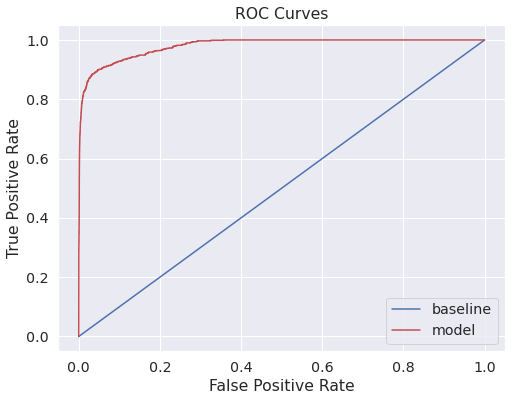

In [223]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

randomForest = model_xgbrf
randomForest.fit(train_data, train_labels)
train_probs = randomForest.predict_proba(train_data)
probs = randomForest.predict_proba(test_data)

y_pred = randomForest.predict(test_data)
train_predictions = randomForest.predict(train_data)

print('Train ROC AUC Score:', roc_auc_score(train_labels, train_probs, multi_class='ovo'))
print('Test ROC AUC  Score:', roc_auc_score(test_labels, probs, multi_class='ovo'))

y_test = test_labels
y_train = train_labels
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))], average='macro')
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))], average='macro')
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred, average='macro')
    results['precision'] = precision_score(y_test, y_pred, average='macro')
    results['roc'] = roc_auc_score(y_test, probs, average='macro', multi_class = 'ovo')
    train_results = {}
    train_results['recall'] = recall_score(y_train,train_predictions, average='macro')
    train_results['precision'] = precision_score(y_train, train_predictions, average='macro')
    train_results['roc'] = roc_auc_score(y_train, train_probs, average='macro', multi_class = 'ovo')
    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))], pos_label=1)
    model_fpr, model_tpr, _ = roc_curve(y_test, probs[:,1],pos_label=1)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
evaluate_model(y_pred,probs,train_predictions,train_probs)

The team followed a holistic evaluation strategy consisting of Graphical, Qualitative and Quantitative methods. A human-centered approach was maintained, by following the vision of the Human Centered Technology Cluster. 

#### 3.5.1 Graphical Evaluation Methods

##### a) Line Charts

For the ANN,12 line-charts plotted the training and validation  accuracy for each cross validation fold. These graphs were combined to produce two line charts which represent Training Accuracy v/s Epoch Number and Testing Accuracy v/s Epoch Number alongside the average accuracy value.
A line-chart was used to visualize the ANN’s predicted probabilities of all class-labels, against one test-sample. 
17 line-charts, alongside color-coded event markers, were used to visualize the timing of occurrence of events.


##### b) Box-Plots

For the ANN, a box-plot visualized the mean test accuracy of the 12-Fold Cross-Validation.
For the XGBRandomForest, two boxplots visualized the effects of hyper-parameter tuning. 
Boxplots were also used to visualize the cross-validation accuracy of the classifiers under simple and multiple resampling conditions.


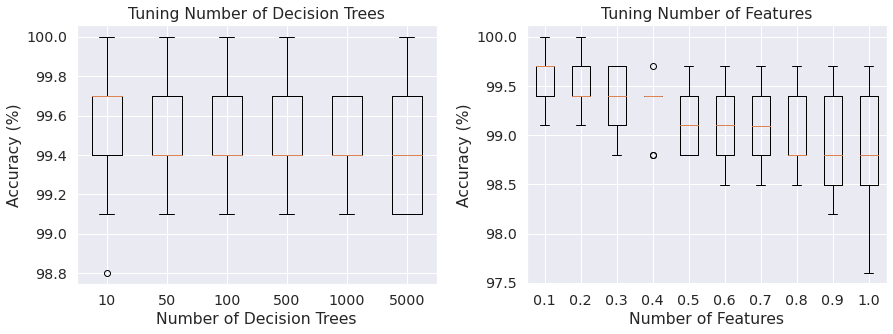

In [224]:
# Random Forest Hyper-parameter tuning

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot


#Optimizing Number of Decision Trees

#Make multiple random forests with different number of decision trees
def make_variable_tree_models():
    models_dict = dict()
    
    #Number of Trees
    n_trees = [10, 50, 100, 500, 1000, 5000]
    
    for trees in n_trees:
        models_dict[str(trees)] = XGBRFClassifier(n_estimators=trees, subsample=0.9, colsample_bynode=0.2)
    
    return models_dict
 
# calculate model accuracy using cross-validation
def run_cv_on_model_trees(model, X, y):
    # Defince CV conditions
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    
    # Calculate Accuracy
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return acc * 100
 
# Setup Dataset
test_data = files_data_all[0]
test_labels = files_labels_all[0]
X, y = test_data[:1000], test_labels[:1000]

#Get multiple random forest models with different number of decision trees
randomForests = make_variable_tree_models()

# Run CV on all models and compare accuracies for varying number of trees
accuracies_all, num_trees_all = list(), list()

for num_trees, randomForest in randomForests.items():
    # Run CV and store returned accuracy
    accuracies = run_cv_on_model_trees(randomForest, X, y)

    # Cache Accuracies and Number of Trees
    accuracies_all.append(accuracies)
    num_trees_all.append(num_trees)
    

#Optimizing Number of Features


#Make multiple random forests with different number of features
def make_variable_features_models():
    
    models_dict = dict()
    
    for num_features in np.arange(0.1, 1.1, 0.1):
        num_features_key = '%.1f' % num_features
        models_dict[num_features_key] = XGBRFClassifier(n_estimators=100, subsample=0.9, colsample_bynode=num_features)
    
    return models_dict
 
# calculate model accuracy using cross-validation
def run_cv_on_model_features(model, X, y):
    # Defince CV conditions
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    
    # Calculate Accuracy
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return acc * 100
 

#Get multiple random forest models with different number of features
randomForests = make_variable_features_models()

# Run CV on all models and compare accuracies for varying number of features
accuracies_all_features, num_features_all = list(), list()

for num_features, randomForest in randomForests.items():
    # Run CV and store returned accuracy
    accuracies = run_cv_on_model_features(randomForest, X, y)

    # Cache Accuracies and Number of features
    accuracies_all_features.append(accuracies)
    num_features_all.append(num_features)

# plot all accuracies to compare effect of changing number of features
pyplot.subplot(1,2,1)
pyplot.boxplot(accuracies_all, labels=num_trees_all)
pyplot.title("Tuning Number of Decision Trees")
pyplot.xlabel("Number of Decision Trees")
pyplot.ylabel("Accuracy (%)")


pyplot.subplot(1,2,2)
pyplot.boxplot(accuracies_all_features, labels=num_features_all)
pyplot.title("Tuning Number of Features")
pyplot.xlabel("Number of Features")
pyplot.ylabel("Accuracy (%)")

pyplot.subplots_adjust(right = 2,bottom = 0.1, top = 1, wspace=0.25)
pyplot.show()

##### c) Bar-Graphs 

Bar-graphs were used to visualize the distribution of classification labels in the dataset.

##### d) Scatter-Plots

Scatter-plots were used to compare the timing of true-events and predicted-events. This was done using 2 adjacent scatter-plots.

#### 3.5.2 Qualitative Evaluation Methods

The team’s qualitative evaluation strategy was governed by Human-in-the-Loop Data Analytics principles. We used a cognitive walkthrough to evaluate keyboard layouts, and value proposition canvases to compare the fit between user-profile and product values for various prototype iterations. 

Cognitive Walkthrough: To ensure that users understood the intended meaning of the keyboard visualization, contextual cues are provided at each node about traversal choices. To ensure attention is paid to these cues, a new color was assigned to them. To ensure the users understood the relevant parts of the keyboard, all keys were labeled using de facto symbols/terms. User discovery of action sequences was facilitated by the addition of cues, and to ensure the users understood the outcome of their choice, the text-box and the haptic communicator provided feedback.

Value Proposition Canvas: We developed a value map for each prototype iteration, to assess the fit between the solutions we developed, and the problems users face. These value maps were compared based on their ability to alleviate user-pains, enhance user-gains and completion capability of user jobs.


#### 3.5.3 Quantitative Evaluation Methods

The quantitative evaluation strategy was inspired by figure 5.1 of (Japkowicz & Shah, 2011), the error estimation methods used for each of the resampling categories are:
 
 a) No-Resampling:
  
    i) Hold-out evaluation;
 
 b) Simple-Resampling:
  
    i) Stratified 5-Fold Cross-Validation;
 
 c) Multiple-Resampling:
  
    i) Repeated 5-fold Cross-Validation;


In [ ]:
# Classifiers for Quatitative Evaluation, trained on a subset of training data

train_data_subset = train_data[0:10000]
train_labels_subset = train_labels[0:10000]
print("training data has been split, building models now")

#SVM
svm_clf = svm.SVC()
svm_clf.fit(train_data_subset, train_labels_subset)
print("SVM has been trained for hold-out evaluation")

# XGB Random Forest
xgbrf_clf = XGBRFClassifier(n_estimators=1000, subsample=0.9, colsample_bynode=0.1).fit(train_data_subset, train_labels_subset)
print("XGBRandomForest has been trained for hold-out evaluation")


# ANN
ann_clf = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dense(OUTPUT_SHAPE)
])

ann_clf.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 50

ann_clf_history = ann_clf.fit(
          train_data_subset,
          train_labels_subset,
          epochs = EPOCHS,
          validation_data=(test_data, test_labels)
)
print("ANN has been trained for hold-out evaluation")


In [228]:
def confusion_matrix_ml_models(model ,data, labels):
    model_probs = model.predict(data)
    preds = tf.nn.softmax(model_probs, axis=1)
    # print(predictions)

    event_pred = np.argmax(preds, axis=1)
    # print(event_pred)

    return confusion_matrix(event_pred, labels)

In [229]:
#Quantitative Evaluation 1: Hold-out evaluation (No-resampling)

svm_predictions_holdout = svm_clf.predict(test_data[:1000])
print("SVM predictions complete")
xgbrf_predictions_holdout = xgbrf_clf.predict(test_data[:1000])
print("XGBRF predictions complete")

cnf_matrix_svm = confusion_matrix(svm_predictions_holdout, test_labels[:1000])
print("SVM confusion matrix generated")
cnf_matrix_xgbrf = confusion_matrix(xgbrf_predictions_holdout, test_labels[:1000])
print("XGBRF confusion matrix generated")
cnf_matrix_ann = confusion_matrix_ml_models(ann_clf, test_data[:1000], test_labels[:1000])
print("ANN confusion matrix generated")

print("------------------------------------------------")
print("Hold out evaluation confusion matrices are")
print("Confusion Matrix for SVM:")
print_confusion_matrix(cnf_matrix_svm)
print("------------------------------------------------")

print("Confusion Matrix for XGBRF:")
print_confusion_matrix(cnf_matrix_xgbrf)
print("------------------------------------------------")

print("Confusion Matrix for ANN:")
print_confusion_matrix(cnf_matrix_ann)
print("------------------------------------------------")

SVM predictions complete
XGBRF predictions complete
SVM confusion matrix generated
XGBRF confusion matrix generated
ANN confusion matrix generated
------------------------------------------------
Hold out evaluation confusion matrices are
Confusion Matrix for SVM:
[[894   7]
 [  6  93]]
Overall accuracy: 98.70% (987/1000)
False positives 7
True positives 99
False discovery (fp/(tp+fp)): 0.0660 (7/106)
Event N (0) accuracy:    894/901    (t_acc 99.22%)
Event L (1) accuracy:     93/99     (t_acc 93.94%) (e_acc 100.00%)

------------------------------------------------
Confusion Matrix for XGBRF:
[[899   1]
 [  1  99]]
Overall accuracy: 99.80% (998/1000)
False positives 1
True positives 100
False discovery (fp/(tp+fp)): 0.0099 (1/101)
Event N (0) accuracy:    899/900    (t_acc 99.89%)
Event L (1) accuracy:     99/100    (t_acc 99.00%) (e_acc 100.00%)

------------------------------------------------
Confusion Matrix for ANN:
[[900  10]
 [  0  90]]
Overall accuracy: 99.00% (990/1000)
False

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

seed = 7
np.random.seed(seed)

def ann_scikit_wrapped():
    model = Sequential()
    model.add(Flatten(input_shape=INPUT_SHAPE))
    model.add(Dropout(.25, input_shape=INPUT_SHAPE))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2, input_shape=(64,)))
    model.add(Dense(16, activation='relu'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model
    

ann_clf_wrapped = KerasClassifier(build_fn=ann_scikit_wrapped, epochs=50, batch_size = 32, verbose=0)

In [ ]:
#Quantitative Evaluation 2: Stratified K-Fold cross validation (simple-resampling)
from sklearn.model_selection import StratifiedKFold


sfk = StratifiedKFold(n_splits = 5)

print("Starting Stratified 5 fold cross validation on SVM")
svm_sfk_score = cross_val_score(svm_clf, train_data_subset, 
                                train_labels_subset,
                               scoring='accuracy',
                               cv=sfk,
                               n_jobs=-1)

print("Starting Stratified 5 fold cross validation on XGBRF")
xgbrf_sfk_score = cross_val_score(xgbrf_clf, train_data_subset, 
                                train_labels_subset,
                               scoring='accuracy',
                               cv=sfk,
                               n_jobs=-1)

print("Starting Stratified 5 fold cross validation on ANN")
ann_sfk_score = cross_val_score(ann_clf_wrapped, train_data_subset, 
                                train_labels_subset,
                               scoring='accuracy',
                               cv=sfk,
                               n_jobs=-1)


print("Stratified 5 fold cross validation completed on all models, reporting performance")
print("-------------------------------------------------------")
print('Accuracy SVM: %.3f (%.3f)' % (np.mean(svm_sfk_score), np.std(svm_sfk_score)))
print('Accuracy XGBRF: %.3f (%.3f)' % (np.mean(xgbrf_sfk_score), np.std(xgbrf_sfk_score)))
print('Accuracy ANN: %.3f (%.3f)' % (np.mean(ann_sfk_score), np.std(ann_sfk_score)))

In [235]:
#Quantitative Evaluation 3: Repeated K-Fold cross validation (multiple-resampling)\
from sklearn.model_selection import RepeatedKFold

cv_multiple_resampling = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state=1)

print("Starting Repeated 5 fold cross validation on SVM")
svm_multiple_resampling_score = cross_val_score(svm_clf, 
                                                train_data_subset, 
                                                train_labels_subset, 
                                                scoring='accuracy',
                                               cv = cv_multiple_resampling,
                                               n_jobs=-1)

print("Starting Repeated 5 fold cross validation on XGBRF")
xgbrf_multiple_resampling_score = cross_val_score(xgbrf_clf, 
                                                train_data_subset, 
                                                train_labels_subset, 
                                                scoring='accuracy',
                                               cv = cv_multiple_resampling,
                                               n_jobs=-1)

print("Starting Repeated 5 fold cross validation on ANN")
ann_multiple_resampling_score = cross_val_score(ann_clf_wrapped, 
                                                train_data_subset, 
                                                train_labels_subset, 
                                                scoring='accuracy',
                                               cv = cv_multiple_resampling,
                                               n_jobs=-1)


print("Repeated 5 fold cross validation completed on all models, reporting performance")
print("-------------------------------------------------------")
print('Accuracy SVM: %.3f (%.3f)' % (np.mean(svm_multiple_resampling_score), np.std(svm_multiple_resampling_score)))
print('Accuracy XGBRF: %.3f (%.3f)' % (np.mean(xgbrf_multiple_resampling_score), np.std(xgbrf_multiple_resampling_score)))
print('Accuracy ANN: %.3f (%.3f)' % (np.mean(ann_multiple_resampling_score), np.std(ann_multiple_resampling_score)))

Starting Repeated 5 fold cross validation on SVM
Starting Repeated 5 fold cross validation on XGBRF
Starting Repeated 5 fold cross validation on ANN


NameError: name 'ann_clf_wrapped' is not defined

In [ ]:
pyplot.subplot(1,2,1)
pyplot.boxplot([svm_sfk_score * 100,xgbrf_sfk_score * 100, ann_sfk_score * 100], labels=["SVM", "XGBRF", "ANN"] ,showmeans=True)
pyplot.title("Simple Resampling Performace")
pyplot.xlabel("Classifier Type")
pyplot.ylabel("Accuracy (%)")

pyplot.subplot(1,2,2)
pyplot.boxplot([svm_multiple_resampling_score * 100,xgbrf_multiple_resampling_score * 100, ann_multiple_resampling_score * 100], labels=["SVM", "XGBRF", "ANN"] ,showmeans=True)
pyplot.title("Multiple Resampling Performace")
pyplot.xlabel("Classifier Type")
pyplot.ylabel("Accuracy (%)")

pyplot.subplots_adjust(wspace = 1, hspace = 1)

pyplot.show()

## 4. Results

### 4.1 Part A - Evaluation Results

In [ ]:
def print_confusion_matrix(conf):
    print(conf)
    
    overall_total = sum(sum(conf))
    overall_correct = sum([conf[i][i] for i in range(len(conf))])
    print(f"Overall accuracy: {100*overall_correct/overall_total:.2f}% ({overall_correct}/{overall_total})")
    
    fp = sum(conf[0][1:])
    tp = sum(sum(conf[1:]))
    print(f"False positives {fp}")
    print(f"True positives {tp}")
    print(f"False discovery (fp/(tp+fp)): {fp/(fp+tp):.4f} ({fp}/{fp+tp})")
    
    for i in range(len(conf)):
        letter = str(EVENT_ID_LETTER_MAP[i])[0]
        
        total = sum(conf[i])
        correct = conf[i][i]
        acc_total = 100*correct/total
        
        s = f"Event {letter} ({i}) accuracy: {correct:6}/{total: <6} (t_acc {acc_total:5.2f}%)"
        if i > 0:
            acc_event = 100*correct/(total - conf[i][0])
            s += f" (e_acc {acc_event:5.2f}%)"
        print(s)
        
    print("")

    return conf

In [ ]:
total_conf_ann = np.sum(cv_conf_ann, axis=0)
print_confusion_matrix(total_conf_ann)

total_conf_svm = np.sum(cv_conf_svm, axis=0)
print_confusion_matrix(total_conf_svm)

total_conf_rf = np.sum(cv_conf_rf, axis=0)
print_confusion_matrix(total_conf_rf)

In [233]:
def get_table(conf_array):
    final_table = np.zeros((9,3))
    for index, conf in enumerate(conf_array):
        store = []
        overall_total = sum(sum(conf))
        overall_correct = tf.linalg.trace(conf)
        overall_accuracy = 100*overall_correct/overall_total
        fp = sum(conf[0][1:])
        tp = sum(sum(conf[1:]))
        fdr_tot = fp/(fp+tp) # overall FDR
        
        # overall acc
        print(overall_accuracy)
        store = np.append(store, overall_accuracy)
        
        # Acc for each event
        for i in range(len(conf)):
            total = sum(conf[i])
            correct = conf[i][i]
            acc_total = 100*(correct/total)
            store = np.append(store, acc_total)
        store = np.append(store, fdr_tot)
        
        # FDR for each event
        for i in range(1,len(conf)):
            fp = sum([r[i] for r in conf])-conf[i,i]
            tp = conf[i,i]
            fdr_event = fp/(fp+tp)
            store = np.append(store, fdr_event)
            
        final_table[:, index] = store
    return final_table

tf.Tensor(94.78135369176401, shape=(), dtype=float64)
tf.Tensor(94.55083333333333, shape=(), dtype=float64)
tf.Tensor(94.25800534139039, shape=(), dtype=float64)


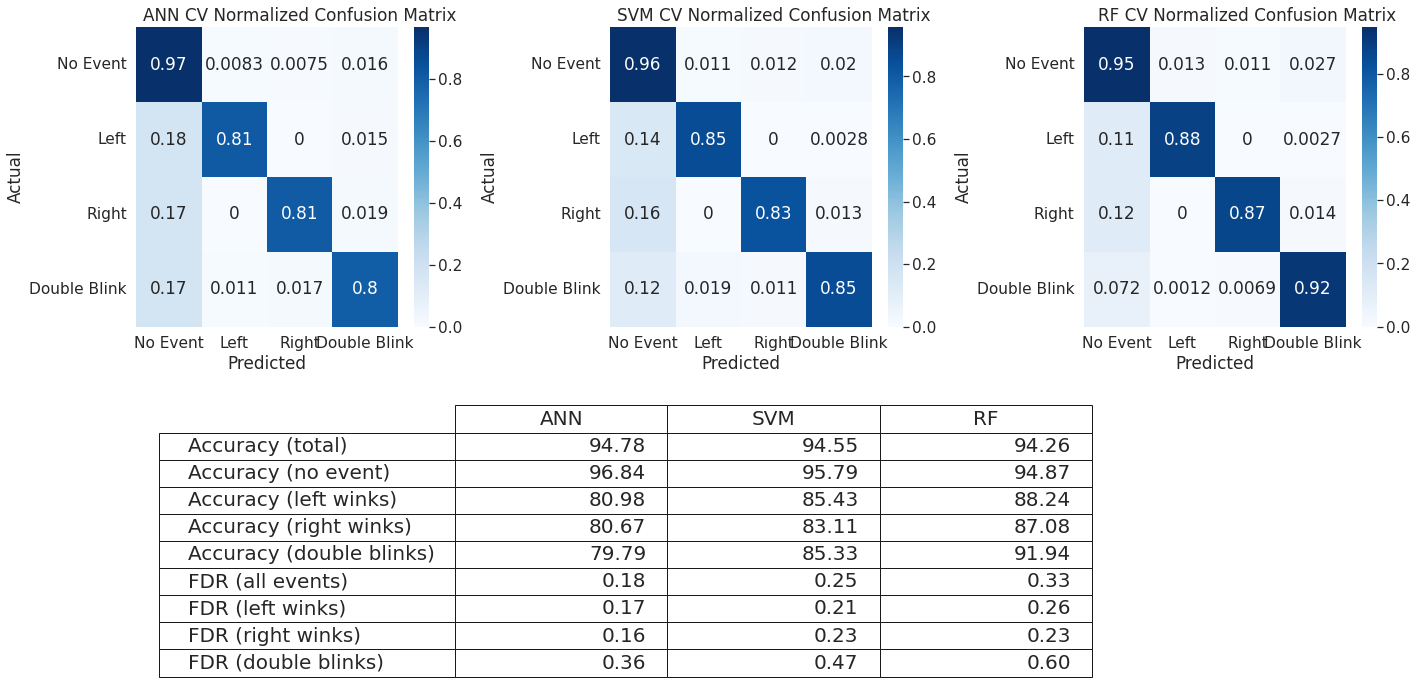

In [234]:
def plotConfMatrix2(models, model_names):
    fig = plt.figure(figsize=(20,10))
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    sns.set(font_scale=1.4)
    gs = fig.add_gridspec(2,3)
    # Normalize plots
    for index, model in enumerate(models):
        normalize = np.sum(model, axis=1)
        model = model/normalize.reshape(-1,1)
        ax = fig.add_subplot(gs[0, index])
        s = sns.heatmap(model, annot=True, cmap='Blues', ax=fig.add_subplot(gs[0,index]), xticklabels=['No Event', 'Left', 'Right', 'Double Blink'], 
        yticklabels=['No Event', 'Left', 'Right', 'Double Blink'])
        s.set(xlabel='Predicted', ylabel='Actual')
        ax.set_title(f'{model_names[index]} CV Normalized Confusion Matrix')
        ax.xaxis.set_ticklabels(['No Event', 'Left', 'Right', 'Dbl Blink'])
        ax.yaxis.set_ticklabels(['No Event', 'Left', 'Right', 'Dbl Blink'], rotation=0)
        ax.axis('off')
        ax.axis('tight')
    ax = fig.add_subplot(gs[1, :])
    columns = ('ANN', 'SVM', 'RF')
    row_labels = [
        "Accuracy (total)",
        "Accuracy (no event)",
        "Accuracy (left winks)",
        "Accuracy (right winks)",
        "Accuracy (double blinks)",
        "FDR (all events)",
        "FDR (left winks)",
        "FDR (right winks)",
        "FDR (double blinks)"
    ]
    table = get_table(models)
    data = []
    for i in range(9):
        data.append([f"{table[i,0]:.2f}", f"{table[i,1]:.2f}", f"{table[i,2]:.2f}"])
#     data = np.random.random((10,3)) #Insert data for all of the columns as array 
    table = ax.table(cellText=data, colLabels=columns, rowLabels=row_labels, loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(20) 
    table.scale(0.5, 2)
    ax.axis('tight')
    ax.axis('off')
    fig.tight_layout()
    plt.show()

plotConfMatrix2(
    [total_conf_ann, total_conf_svm, total_conf_rf],
    ['ANN', 'SVM', 'RF']
)

#### a) Graphical Evaluation

Based on graphical evaluation of cross-validation scores, using simple and multiple resampling, the aggregate accuracies of the classifiers are relatively close, and require quantitative testing to verify whether the differences are statistically significant.


#### b) Quantitative Evaluation

To determine whether the difference in accuracy is statistically significant, the team used principles mentioned in section 6.7 of (Japkowicz & Shah, 2011).

The results of the Friedman Test, for all resampling types, had a p-value greater than 0.05, therefore we accept the Null-Hypothesis, thus the difference in accuracy is statistically insignificant.

The ANN had the lowest false discovery rate amongst the three classifiers under no-resampling conditions, based on their confusion matrices.



In [ ]:
# Friedman Test to check if difference in performance is statistically significant
from scipy import stats

#For No-resampling performance is
print("No-resampling Friedman Test result is {}".format(stats.friedmanchisquare(cnf_matrix_svm, cnf_matrix_xgbrf, cnf_matrix_ann)))

#For simple-resampling performance is
print("Simple-resampling Friedman Test result is {}".format(stats.friedmanchisquare(svm_sfk_score, xgbrf_sfk_score, ann_sfk_score)))

#For multiple-resampling performance is
print("Multiple-resampling Friedman Test result is {}".format(stats.friedmanchisquare(svm_multiple_resampling_score, xgbrf_multiple_resampling_score, ann_multiple_resampling_score)))

#### c) Qualitative Evaluation

The best value-proposition fit for the virtual-keyboard stems from the ANN-integrated version. The cognitive walkthrough highlighted the importance of visual cues and these were added to the final layout.

Thus, we selected the ANN due to its low false discovery rate, faster classification speed, high accuracy and satisfactory value-map fit.


### 4.2 Part B

#### 4.2.1 Deployment Process 

An eye-controlled virtual keyboard was developed based on the ANN model, which classifies eye movements to trigger particular events on the keyboard. 


#### 4.2.2 Description of Keyboard

The keyboard is presented as a 5-layer binary tree with the keys located at the bottom layer and the other nodes left as blanks. This allows users to interact with the keyboard using a minimum number of actions. Specifically, the cursor can be shifted to its left child by a left wink, or to its right child by a right wink. Left or right winks on a leaf node bring the cursor back to the root. The keyboard also supports the functionality of navigating up to the parent by double blinking on the nodes other than the root and the leaves. This allows users to undo the movements of the cursor when a wink is made unintentionally by the user or detected mistakenly by the model. Double blinks are also used as selections. Selecting the leaves either adds the character or the word, or performs certain modifications on the input, such as deleting the last character, starting a newline, etc. Selecting the root enables the switching between the different modes of the keyboard: lowercase alphabets, uppercase alphabets, punctuations and autocomplete. 

#### 4.2.3 Description of Haptic Communicator 

This component ensures that users receive accurate feedback for selections. The set-up code for this device is part of the final codebase; the development of the hardware could be undertaken for future work. 
The HapticSetup.txt file provides more information about the development process.


In [14]:
def print_confusion_matrix(conf):
    print(conf)
    
    overall_total = sum(sum(conf))
    overall_correct = sum([conf[i][i] for i in range(len(conf))])
    print(f"Overall accuracy: {100*overall_correct/overall_total:.2f}% ({overall_correct}/{overall_total})")
    
    fp = sum(conf[0][1:])
    tp = sum(sum(conf[1:]))
    print(f"False positives {fp}")
    print(f"True positives {tp}")
    print(f"False discovery (fp/(tp+fp)): {fp/(fp+tp):.4f} ({fp}/{fp+tp})")
    
    for i in range(len(conf)):
        letter = str(EVENT_ID_LETTER_MAP[i])[0]
        
        total = sum(conf[i])
        correct = conf[i][i]
        acc_total = 100*correct/total
        
        s = f"Event {letter} ({i}) accuracy: {correct:6}/{total: <6} (t_acc {acc_total:5.2f}%)"
        if i > 0:
            acc_event = 100*correct/(total - conf[i][0])
            s += f" (e_acc {acc_event:5.2f}%)"
        print(s)
        
    print("")
        
    return conf

In [15]:
total_conf_ann = np.sum(cv_conf_ann, axis=0)
print_confusion_matrix(total_conf_ann)

total_conf_svm = np.sum(cv_conf_svm, axis=0)
print_confusion_matrix(total_conf_svm)

0.0


TypeError: 'numpy.float64' object is not iterable

## 5. Discussion and Conclusion

### 5.1 Issues Addressed

#### 5.1.1 Issues Addressed in the Development Process

During the initial data collection phase, instructions and timestamps were manually recorded by one team member while another, attached to the SpikerBox, would execute the action. In addition to being inefficient, this process often resulted in misalignment between event timestamps and signal spikes. By developing a UI which integrated and automated instruction read-outs, event logging and simulation of random eye motion, this process was significantly streamlined and the dependency on a second team member removed, allowing more training data to be collected per session. With future implementations, packaging the data collection UI with the virtual keyboard will enable new users to fine tune pre-trained models for better generalisation.


Additionally, the design for the keyboard went through multiple iterations. Initially, a wheel type design was chosen, in order to cycle through all letters with a small amount of inputs. The downside of this design was that the user would have to navigate through more than 13 letters (half of the alphabet + additional punctuation etc) at worst. So a binary tree keyboard layout was chosen with the understanding of it having the shortest navigation times to improve usability of the product. 


It was originally planned to use left and right eye movements for the project. However, this introduced the issue of unintentional movements of the eye being registered as inputs. To counter this, a protocol was suggested of adding double blinks before a horizontal eye movement to ensure the action was intentional.Unsurprisingly, this introduced a worsened user experience due to eye fatigue from the repeated blinking. In the end, winks were chosen as a superior input method.


#### 5.1.2 Limitations

Factors such as electrode placement, ambient luminosity, muscle contraction strength and electrode-skin contact can introduce some level of variability in the EOG waveforms amongst users. For example, depending on electrode placement relative to the source generator (eye), signal amplitudes for left and right winks were observed to vary in magnitude. The complexities in the signals arising from these contributions is expected to have a detrimental effect on the generalisation of the trained model to new-users. However in future implementations, model performance can be improved through larger training sets acquired from hundreds (or thousands) of users in order to capture the full range of potential operating environments, electrode placements and other user-to-user variability.

### 5.2 Future Work

#### 5.2.1 Haptic Communicator  

The prototype provides the set-up code required for integrating haptic-hardware with the virtual-keyboard, to facilitate the development mentioned in 4.2.3. This would require collaboration between Physics, Data Science as well as Engineering disciplines. 

#### 5.2.2 EOG Hardware

Avenues for EOG hardware improvement are:
  
  1) Additional electrodes in the vertical orientation allow for more degrees of freedom in user input.
  
  2) Integration of professional grade EOG hardware. The SpikerBox, is “appropriate for use in middle/high school educational programs and by amateurs” (Marzullo & Gage, 2012).
  
These changes would impact the performance by providing better signals to the classifier, thus creating room for improved input-classification.


### 5.3 Conclusion

The team set-out to develop a virtual-keyboard which could be used by patients suffering from Motor Neuron Diseases, and created a high-fidelity prototype. 

To achieve this, interdisciplinary effectiveness was crucial. The data collected by Physics students was the foundation upon which Data-Science students built classification models, which made the virtual keyboard usable.  
Based on the Human-Centered evaluation strategy, the ANN was used in our final prototype, due to its remarkable performance in all three sub-segments of the evaluation strategy. 

In the future, after the integration/development of the haptic-communicator, better classifiers, professional EOG-hardware and portability-modules, the product will be ready for use not only by MND patients, but anyone who requires hands-free typing. 


## 6. Student Contribution

### 6.1 Matty

My contributions were focused in the Data Science and Computer Science disciplines. Within the product, I worked mainly on the data preprocessing and data classification stages. This involved preparing the data in a form ready for ML, and building the ANN and SVM models. I also worked on the UI, in particular building a data collection interface that allowed for more efficient collection of training data for the models. In the report, I worked mainly on the data aspects of methods and results (Part A), with some contributions to other data-related sections.

### 6.2 Ashwin

As a Data Science and Computer Science disciple, my contributions were:
   
   a) Development of classification models;
   
   b) Qualitative, quantitative and graphical evaluation of models;
   
   c) Development and integration of Haptic Module;
   
   d) Evaluation of keyboard layout;
   
   e) Conducting a literature review on key-board layouts;
   
   f) Writing the report sections 3 , 3.3.2 , 3.3.3, 3.4, 3.4.1, 3.4.2,3.4.3, 4.1.1, 4.1.5 , 5.2.1, 5.2.2 and 5.3; 
   
   g) Presentation slides for product introduction 
   
I also helped during the data collection process.
I would like to acknowledge the constant support and feedback the teammates provided me with. 



### 6.3 Marcus

Focused on initial data analysis using R, report writing (part of methods, aims, plus editing report overall) , presentation production (spoke on user experience and conclusion in presentation), discussing and brainstorming as well as script writing. Also used to collect training data for the product. 

### 6.4. Alex

Using my physics background, I contributed to initial product development and brainstorming the implementation of keyboard designs as well as participating in multiple data collection sessions. Within them, I worked with Josh to ensure the data collected for the classifier was as high quality as possible, incorporating random movements of the eye and experimenting with different electrode placements, spiker boxes, and members of the group. Finally, I edited and presented the slides on data collection, as well as collaborated on the report focusing mainly on the physics background and discussion components.

### 6.5. Jingyu

As a data student with coding experience, I contributed in:
- Idea generation and prototype creation of the binary tree keyboard layout;
- Implementation of Pygame-based user interface;
- Improvement of UI features and functionalities in the evaluation phase;
- Integrating classification model and UI
- Participation in presentation and report writing.


### 6.9. Josh


As a physics student my primary role in the project involved working directly with the SpikerBox to determine optimal electrode placement and writing code to stream raw data in both MATLAB and python. Furthermore, I tested a range of digital filters and experimented with fine-tuning filter parameters. I participated in data collection by instructing actions based on pre-determined sequences as well as performing the actions myself. In the presentation, I contributed to slide design and provided a live demonstration of the virtual keyboard. Additionally, I contributed to writing and editing the background and discussion sections in the final report as well as the ANN, confusion matrix and data flow diagrams. 

## References

1) What is ALS/MND?. (2022). Retrieved 8 May 2022, from https://www.als-mnd.org/what-is-alsmnd/#:~:text=Although%20classified%20as%20a%20rare,384%20new%20cases%20every%20day!

2) Bulling, Andreas; Ward, Jamie A.; Gellersen, Hans; Tröster, Gerhard (2009). [ACM Press the 11th international conference - Orlando, Florida, USA (2009.09.30-2009.10.03)] Proceedings of the 11th international conference on Ubiquitous computing - Ubicomp '09 - Eye movement analysis for activity recognition. , (), 41–. doi:10.1145/1620545.1620552 

3) Tufte, E. (1986). The visual display of quantitative information. Retrieved 27 May 2022, from https://dl.acm.org/doi/10.5555/33404

4) Tufte, E. (1990). Envisioning information. Retrieved 27 May 2022, from https://dl.acm.org/doi/10.5555/78223

5) Tufte, E. (1997). Visual explanations:images and quantities, evidence and narrative. Retrieved 27 May 2022, from https://dl.acm.org/doi/10.5555/248468

6) Tufte, E. (2006). Beautiful Evidence. Retrieved 27 May 2022, from https://dl.acm.org/doi/book/10.5555/1198006

7) Japkowicz, N., & Shah, M. (2011). Evaluating Learning Algorithms:A Classification Perspective. Retrieved 27 May 2022, from https://dl.acm.org/doi/10.5555/1964882

8) Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Retrieved 28 May 2022, from https://dl.acm.org/doi/pdf/10.1145/2939672.2939785 

9) Marzullo, T., & Gage, G. (2012). The SpikerBox: A Low Cost, Open-Source BioAmplifier for Increasing Public Participation in Neuroscience Inquiry. Retrieved 29 May 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3310049/ 

10) Guenther, N. and Schonlau, M., 2016. Support Vector Machines. [online] SAGE journals. Available at: <https://journals.sagepub.com/doi/10.1177/1536867X1601600407> [Accessed 28 May 2022].

11) 9) Breiman, L., & Cutler, A. (2006). Random forests - copyright. Retrieved 28 May 2022, from https://www.stat.berkeley.edu/~breiman/RandomForests/cc_copyright.htm
